# Projeto Disciplina KDD & Desafio Axondata

## Foco: Covid-19

### Ideia 2
Realizar agrupamentos de séries temporais relativas ao COVID-19, pra verificar quais países tem comportamentos similares em termos de casos confirmados, casos recuperados e óbitos. Agregar dados demográficos e analisar se isto impacta no agrupamento dos países.

Utiliza a base da JHU no formato original, onde há uma coluna pra cada data e não há colunas adicionais de identificação dos países e regiões (alpha_code, region_code, subregion_code e intermediateregion_code)

## Configuração Biblioteca e Spark

In [42]:
# importar bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import col
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [2]:
# criar contexto e configuração para o Spark
conf = SparkConf().setAppName("Covid-19 EDA")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

## Explorar Dados - JHU (John Hopkins University)

In [65]:
# ler arquivo de casos mundiais confirmados para dataframe Spark
confirmed_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_confirmed_global.csv', sep=',', header=True)

# ler arquivo de casos recuperados mundiais para dataframe Spark
recovered_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_recovered_global.csv', sep=',', header=True)

# ler arquivo de obitos mundiais para dataframe Spark
deaths_world_cases = sqlContext.read.csv('../datasets/time_series_covid19_deaths_global.csv', sep=',', header=True)

In [66]:
# converte colunas de datas em linhas com melt
confirmed_world_cases_pd = confirmed_world_cases.toPandas().melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="date", value_name="Value")
recovered_world_cases_pd = recovered_world_cases.toPandas().melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="date", value_name="Value")
deaths_world_cases_pd = deaths_world_cases.toPandas().melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="date", value_name="Value")

In [67]:
# converte tipos das colunas para os formatos corretos

# Lat
confirmed_world_cases_pd.Lat = confirmed_world_cases_pd.Lat.astype(float)
recovered_world_cases_pd.Lat = recovered_world_cases_pd.Lat.astype(float)
deaths_world_cases_pd.Lat = deaths_world_cases_pd.Lat.astype(float)

# Long
confirmed_world_cases_pd.Long = confirmed_world_cases_pd.Long.astype(float)
recovered_world_cases_pd.Long = recovered_world_cases_pd.Long.astype(float)
deaths_world_cases_pd.Long = deaths_world_cases_pd.Long.astype(float)

# Date
confirmed_world_cases_pd.date = pd.to_datetime(confirmed_world_cases_pd.date)
recovered_world_cases_pd.date = pd.to_datetime(recovered_world_cases_pd.date)
deaths_world_cases_pd.date = pd.to_datetime(deaths_world_cases_pd.date)

# Value
confirmed_world_cases_pd.Value = confirmed_world_cases_pd.Value.astype(int)
recovered_world_cases_pd.Value = recovered_world_cases_pd.Value.astype(int)
deaths_world_cases_pd.Value = deaths_world_cases_pd.Value.astype(int)

In [68]:
confirmed_world_cases_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29260 entries, 0 to 29259
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  9020 non-null   object        
 1   Country/Region  29260 non-null  object        
 2   Lat             29260 non-null  float64       
 3   Long            29260 non-null  float64       
 4   date            29260 non-null  datetime64[ns]
 5   Value           29260 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 1.3+ MB


In [69]:
# Recria Spark dataframes, com estrtutura nova
schema_jhu = StructType([StructField('province_state', StringType(), True),
                         StructField('country_region', StringType(), True),
                         StructField('lat', FloatType(), True),
                         StructField('long', FloatType(), True),
                         StructField('date', TimestampType(), True),
                         StructField('value', IntegerType(), True)])

confirmed_world_cases = sqlContext.createDataFrame(confirmed_world_cases_pd, schema=schema_jhu)
recovered_world_cases = sqlContext.createDataFrame(recovered_world_cases_pd, schema=schema_jhu)
deaths_world_cases = sqlContext.createDataFrame(deaths_world_cases_pd, schema=schema_jhu)

In [70]:
# verificar estrutura do dataframe de casos mundiais confirmados
confirmed_world_cases.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- value: integer (nullable = true)



In [71]:
# contagem de objetos de cada dataframe
print("Total de Objetos (base de infectados): {}".format(confirmed_world_cases.count()))
print("Total de Objetos (base de recuperados): {}".format(recovered_world_cases.count()))
print("Total de Objetos (base de óbitos): {}".format(deaths_world_cases.count()))

Total de Objetos (base de infectados): 29260
Total de Objetos (base de recuperados): 27720
Total de Objetos (base de óbitos): 29260


In [72]:
# renomear colunas do dataframe
# como estou usando um schema pros CSVs da JHU, trago todos com o campo Value e renomeio para o nome correto
confirmed_world_cases = confirmed_world_cases.withColumnRenamed("Value", "confirmed")
recovered_world_cases = recovered_world_cases.withColumnRenamed("Value", "recovered")
deaths_world_cases = deaths_world_cases.withColumnRenamed("Value", "deaths")

In [73]:
# Realizar o Merge dos Dataframes em um só
join_condition_1 = [confirmed_world_cases.province_state.eqNullSafe(recovered_world_cases.province_state), \
                    confirmed_world_cases.date == recovered_world_cases.date, \
                    confirmed_world_cases.country_region == recovered_world_cases.country_region]


temp_df = confirmed_world_cases.join(recovered_world_cases, \
                                     on=join_condition_1, how="left") \
                                     .select(confirmed_world_cases.province_state, \
                                             confirmed_world_cases.country_region, \
                                             confirmed_world_cases.lat, \
                                             confirmed_world_cases.long, \
                                             confirmed_world_cases.date, \
                                             confirmed_world_cases.confirmed,
                                             recovered_world_cases.recovered)

join_condition_2 = [temp_df.province_state.eqNullSafe(deaths_world_cases.province_state), \
                    temp_df.date == deaths_world_cases.date, \
                    temp_df.country_region == deaths_world_cases.country_region]

complete_world_df = temp_df.join(deaths_world_cases, \
                                 on=join_condition_2, how="left") \
                                 .select(temp_df.province_state, \
                                         temp_df.country_region, \
                                         temp_df.lat, \
                                         temp_df.long, \
                                         temp_df.date, \
                                         temp_df.confirmed,
                                         temp_df.recovered,
                                         deaths_world_cases.deaths)

In [74]:
# Contagem de objetos do dataframe completo
print("Total de Objetos (base consolidada) : {}".format(complete_world_df.count()))

Total de Objetos (base consolidada) : 29260


In [75]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,confirmed,recovered,deaths
0,None,Tanzania,-6.369000,34.888802,2020-01-23,0,0,0
1,None,India,21.000000,78.000000,2020-01-27,0,0,0
2,None,Rwanda,-1.940300,29.873899,2020-01-31,0,0,0
3,None,Saint Vincent and the Grenadines,12.984300,-61.287201,2020-02-01,0,0,0
4,None,Botswana,-22.328501,24.684900,2020-02-03,0,0,0
5,None,Italy,43.000000,12.000000,2020-02-03,2,0,0
6,None,Equatorial Guinea,1.500000,10.000000,2020-02-06,0,0,0
7,None,Thailand,15.000000,101.000000,2020-02-07,25,5,0
8,None,Ecuador,-1.831200,-78.183403,2020-02-08,0,0,0
9,None,Kosovo,42.602634,20.902977,2020-02-08,0,0,0


In [76]:
# remover linhas onde confirmed, recovered e deaths seja igual a zero
complete_world_df = complete_world_df.filter("confirmed != 0 and recovered != 0 and deaths != 0")

In [77]:
# Contagem de objetos do dataframe completo
print("Total de Objetos (base consolidada) : {}".format(complete_world_df.count()))

Total de Objetos (base consolidada) : 10565


In [79]:
# Criar coluna com qtde_dias desde o ínicio, pra cada país
column_list = ['province_state', 'country_region']

complete_world_df = complete_world_df.select("province_state","country_region","lat", "long", "date", \
                                             "confirmed", "recovered", "deaths", F.row_number()\
                                             .over(Window.partitionBy([col(x) for x in column_list]) \
                                             .orderBy(complete_world_df['date'])).alias("num_days"))

In [80]:
# Estrutura Dataframe consolidado
complete_world_df.printSchema()

root
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- recovered: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)



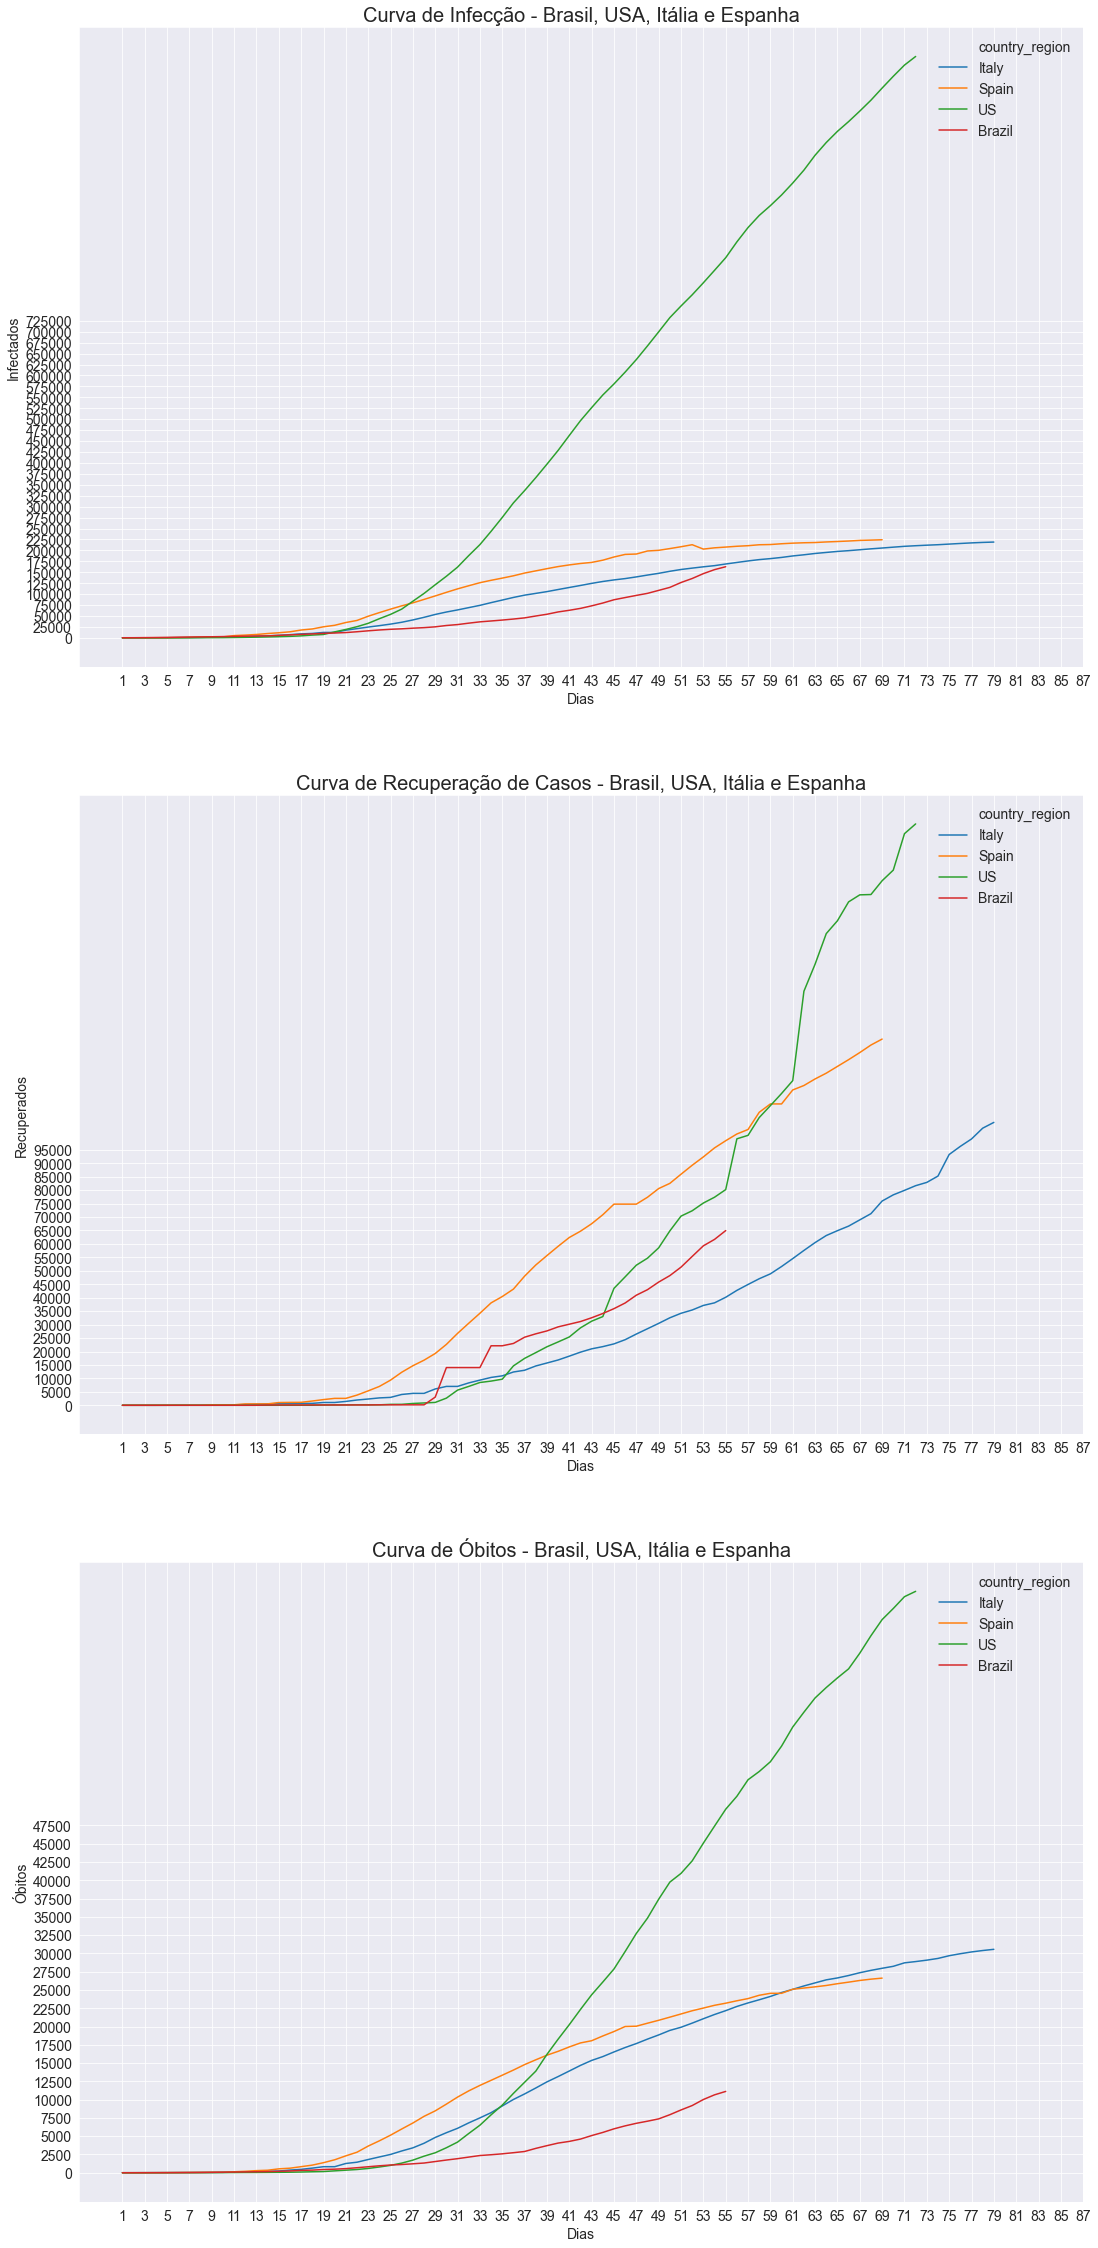

In [81]:
# Gerar gráficos comparando Brasil, Espanha, Italia e USA
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[0].set_xticks(np.arange(1, 89, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Brasil, USA, Itália e Espanha", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[1].set_xticks(np.arange(1, 89, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Curva de Recuperação de Casos - Brasil, USA, Itália e Espanha", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil", "Spain", "US", "Italy"])).toPandas())
ax[2].set_xticks(np.arange(1, 89, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=14)
ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Curva de Óbitos - Brasil, USA, Itália e Espanha", fontsize=20)

plt.show()

## Explorar Base de Dados - Brasil.io

In [99]:
# Schema para Ler os Dados dos Casos da Base Brasil.IO
schema_brasil_io = StructType([StructField('date', TimestampType(), True),
                        StructField('state', StringType(), True),
                        StructField('city', StringType(), True),
                        StructField('place_type', StringType(), True),
                        StructField('confirmed', IntegerType(), True),
                        StructField('deaths', IntegerType(), True),
                        StructField('num_days', IntegerType(), True),
                        StructField('is_last', BooleanType(), True),
                        StructField('estimated_population_2019', IntegerType(), True),
                        StructField('confirmed_by_100k_inhabitants', FloatType(), True),
                        StructField('death_rate', FloatType(), True)])

# ler arquivo de casos mundiais confirmados para dataframe Spark
brasil_io_cases = sqlContext.read.csv('../datasets/caso.csv', sep=',', header=True, schema=schema_brasil_io)

In [100]:
# Contagem de objetos do dataframe Brasil.io
print("Total de Objetos (base consolidada) : {}".format(brasil_io_cases.count()))

Total de Objetos (base consolidada) : 69395


In [101]:
# Estrutura Dataframe consolidado
brasil_io_cases.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- place_type: string (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- deaths: integer (nullable = true)
 |-- num_days: integer (nullable = true)
 |-- is_last: boolean (nullable = true)
 |-- estimated_population_2019: integer (nullable = true)
 |-- confirmed_by_100k_inhabitants: float (nullable = true)
 |-- death_rate: float (nullable = true)



In [102]:
# listar 10 primeiras linhas do dataframe
brasil_io_cases.limit(10).toPandas()

,date,state,city,place_type,confirmed,deaths,num_days,is_last,estimated_population_2019,confirmed_by_100k_inhabitants,death_rate
0,2020-05-10,SE,None,state,1771,34,47,True,2298696,28.0,77.043678
1,2020-05-09,SE,None,state,1588,33,46,False,2298696,28.0,69.082649
2,2020-05-08,SE,None,state,1438,28,45,False,2298696,28.0,62.557209
3,2020-05-07,SE,None,state,1214,25,44,False,2298696,28.0,52.812550
4,2020-05-06,SE,None,state,998,23,43,False,2298696,28.0,43.415920
5,2020-05-05,SE,None,state,898,21,42,False,2298696,28.0,39.065632
6,2020-05-04,SE,None,state,772,17,41,False,2298696,28.0,33.584259
7,2020-05-03,SE,None,state,730,14,40,False,2298696,28.0,31.757139
8,2020-05-02,SE,None,state,601,14,39,False,2298696,28.0,26.145260
9,2020-05-01,SE,None,state,517,14,38,False,2298696,28.0,22.491011


In [104]:
# Ranking - Top 5 Cidades por Casos Confirmados
top_5_brasil_confirmed = brasil_io_cases.select('city','confirmed').filter("date == '2020-05-10' and place_type == 'city'").orderBy('confirmed', ascending=False).limit(5)
top_5_brasil_confirmed.show()

+--------------+---------+
|          city|confirmed|
+--------------+---------+
|     São Paulo|    27307|
|     Fortaleza|    11556|
|Rio de Janeiro|    10520|
|        Manaus|     7198|
|        Recife|     6984|
+--------------+---------+



In [105]:
# Ranking - Top 5 Cidades por Óbitos
top_5_brasil_deaths = brasil_io_cases.select('city','deaths').filter("date == '2020-05-10' and place_type == 'city'").orderBy('deaths', ascending=False).limit(5)
top_5_brasil_deaths.show()

+--------------+------+
|          city|deaths|
+--------------+------+
|     São Paulo|  2266|
|Rio de Janeiro|  1126|
|     Fortaleza|   840|
|        Manaus|   680|
|        Recife|   415|
+--------------+------+



In [106]:
# Cria filtro automatico de cidades para colocar no Gráfico

# filtro top 5 - casos confirmados
filter_confirmed_top5_cities = np.array(top_5_brasil_confirmed.select('city').collect(), dtype = 'object')
filter_confirmed_top5_cities = np.squeeze(filter_confirmed_top5_cities.reshape(filter_confirmed_top5_cities.shape[1], filter_confirmed_top5_cities.shape[0])).tolist()

# filtro top 5 - óbitos
filter_death_top5_cities = np.array(top_5_brasil_deaths.select('city').collect(), dtype = 'object')
filter_death_top5_cities = np.squeeze(filter_death_top5_cities.reshape(filter_death_top5_cities.shape[1], filter_death_top5_cities.shape[0])).tolist()

Text(0.5, 1.0, 'Curva de Óbitos - Top 5 Brasil')

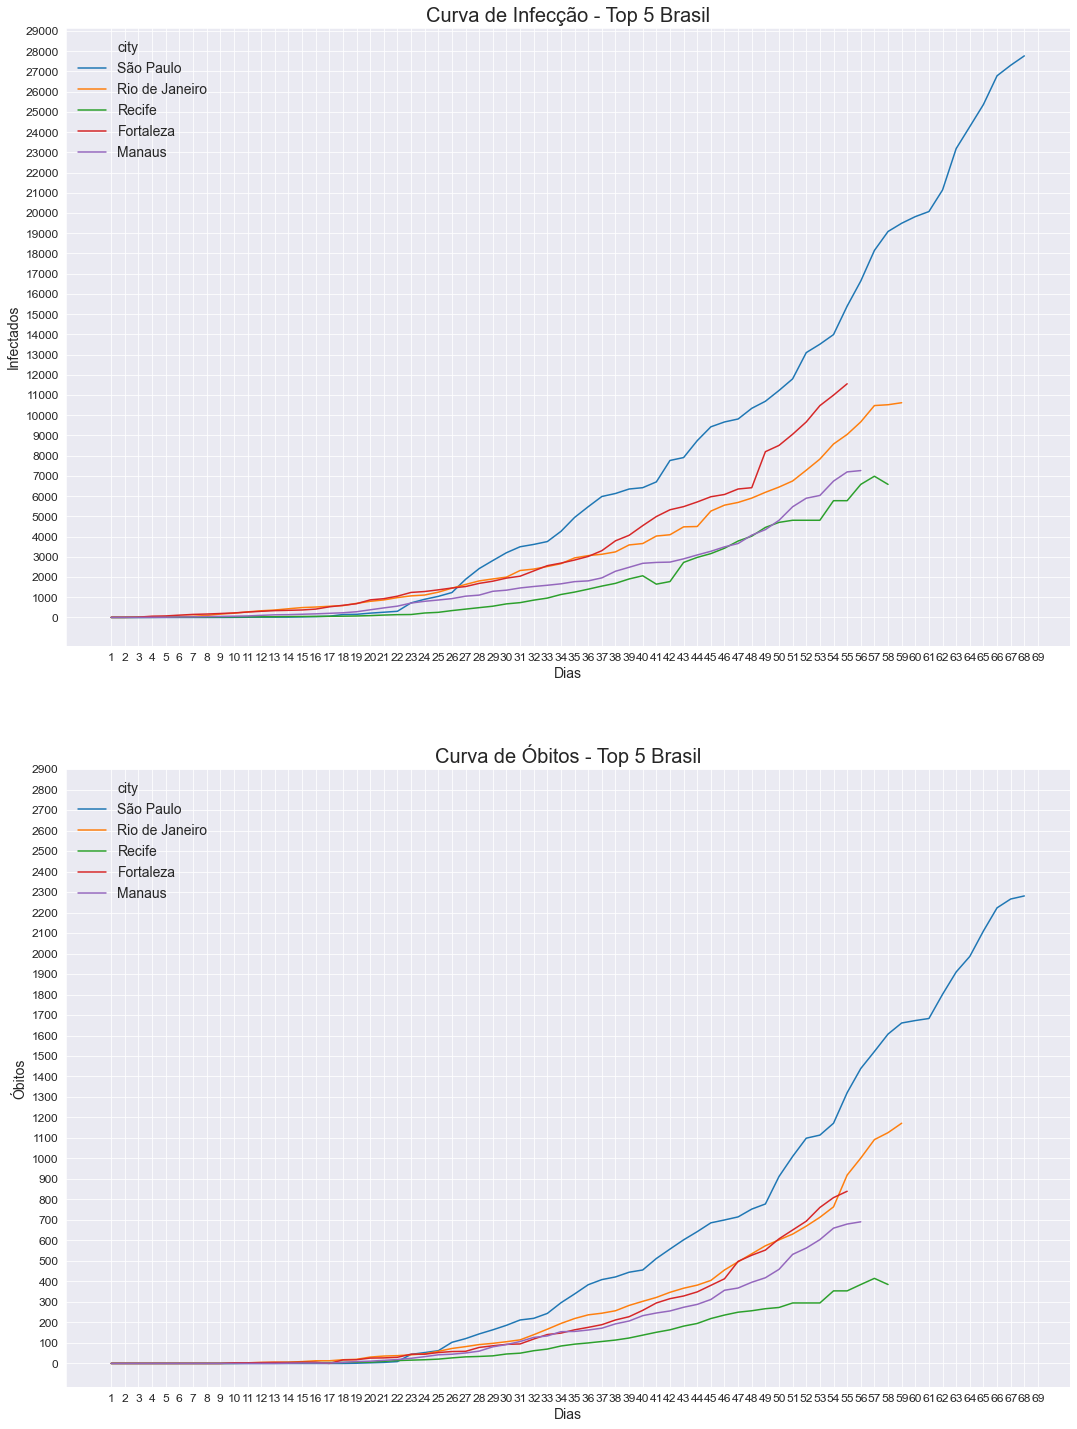

In [111]:
# Gerar gráficos comparando Top 5
fig_dims = (18, 25)
fig, ax = plt.subplots(figsize=fig_dims, nrows=2, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed", hue="city", ax=ax[0], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_confirmed_top5_cities)).toPandas())
ax[0].set_xticks(np.arange(1, 70, 1.0))
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].set_yticks(np.arange(0, 30000, 1000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Curva de Infecção - Top 5 Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths", hue="city", ax=ax[1], data=brasil_io_cases.filter(brasil_io_cases.city.isin(filter_death_top5_cities)).toPandas())
ax[1].set_xticks(np.arange(1, 70, 1.0))
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_yticks(np.arange(0, 3000, 100.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Óbitos", fontsize=14)
ax[1].set_title("Curva de Óbitos - Top 5 Brasil", fontsize=20)

## Gerar Série Temporal para realizar previsões

In [112]:
# Criar Janela de Dados por País, Província e Numero de Dias (poderia ser a data também)
my_window = Window.partitionBy("country_region", "province_state").orderBy("num_days")

In [113]:
# Criar coluna para casos confirmados no dia
complete_world_df = complete_world_df.withColumn("prev_confirmed", F.lag(complete_world_df.confirmed).over(my_window))
complete_world_df = complete_world_df.withColumn("confirmed_day", F.when(F.isnull(complete_world_df.confirmed - complete_world_df.prev_confirmed), 0)
                              .otherwise(complete_world_df.confirmed - complete_world_df.prev_confirmed))

In [114]:
# Criar coluna para casos recuperados no dia
complete_world_df = complete_world_df.withColumn("prev_recovered", F.lag(complete_world_df.recovered).over(my_window))
complete_world_df = complete_world_df.withColumn("recovered_day", F.when(F.isnull(complete_world_df.recovered - complete_world_df.prev_recovered), 0)
                              .otherwise(complete_world_df.recovered - complete_world_df.prev_recovered))

In [115]:
# Criar coluna para óbitos no dia
complete_world_df = complete_world_df.withColumn("prev_deaths", F.lag(complete_world_df.deaths).over(my_window))
complete_world_df = complete_world_df.withColumn("deaths_day", F.when(F.isnull(complete_world_df.deaths - complete_world_df.prev_deaths), 0)
                              .otherwise(complete_world_df.deaths - complete_world_df.prev_deaths))

In [116]:
# Remover as colunas de lag
complete_world_df = complete_world_df.drop(*['prev_confirmed', 'prev_recovered', 'prev_deaths'])

In [117]:
# listar 10 primeiras linhas do dataframe
complete_world_df.limit(10).toPandas()

,province_state,country_region,lat,long,date,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,None,Chad,15.4542,18.732201,2020-04-28,52,19,2,1,0,0,0
1,None,Chad,15.4542,18.732201,2020-04-29,52,19,2,2,0,0,0
2,None,Chad,15.4542,18.732201,2020-04-30,73,33,5,3,21,14,3
3,None,Chad,15.4542,18.732201,2020-05-01,73,33,5,4,0,0,0
4,None,Chad,15.4542,18.732201,2020-05-02,117,39,10,5,44,6,5
5,None,Chad,15.4542,18.732201,2020-05-03,117,39,10,6,0,0,0
6,None,Chad,15.4542,18.732201,2020-05-04,117,39,10,7,0,0,0
7,None,Chad,15.4542,18.732201,2020-05-05,170,43,17,8,53,4,7
8,None,Chad,15.4542,18.732201,2020-05-06,170,43,17,9,0,0,0
9,None,Chad,15.4542,18.732201,2020-05-07,253,50,27,10,83,7,10


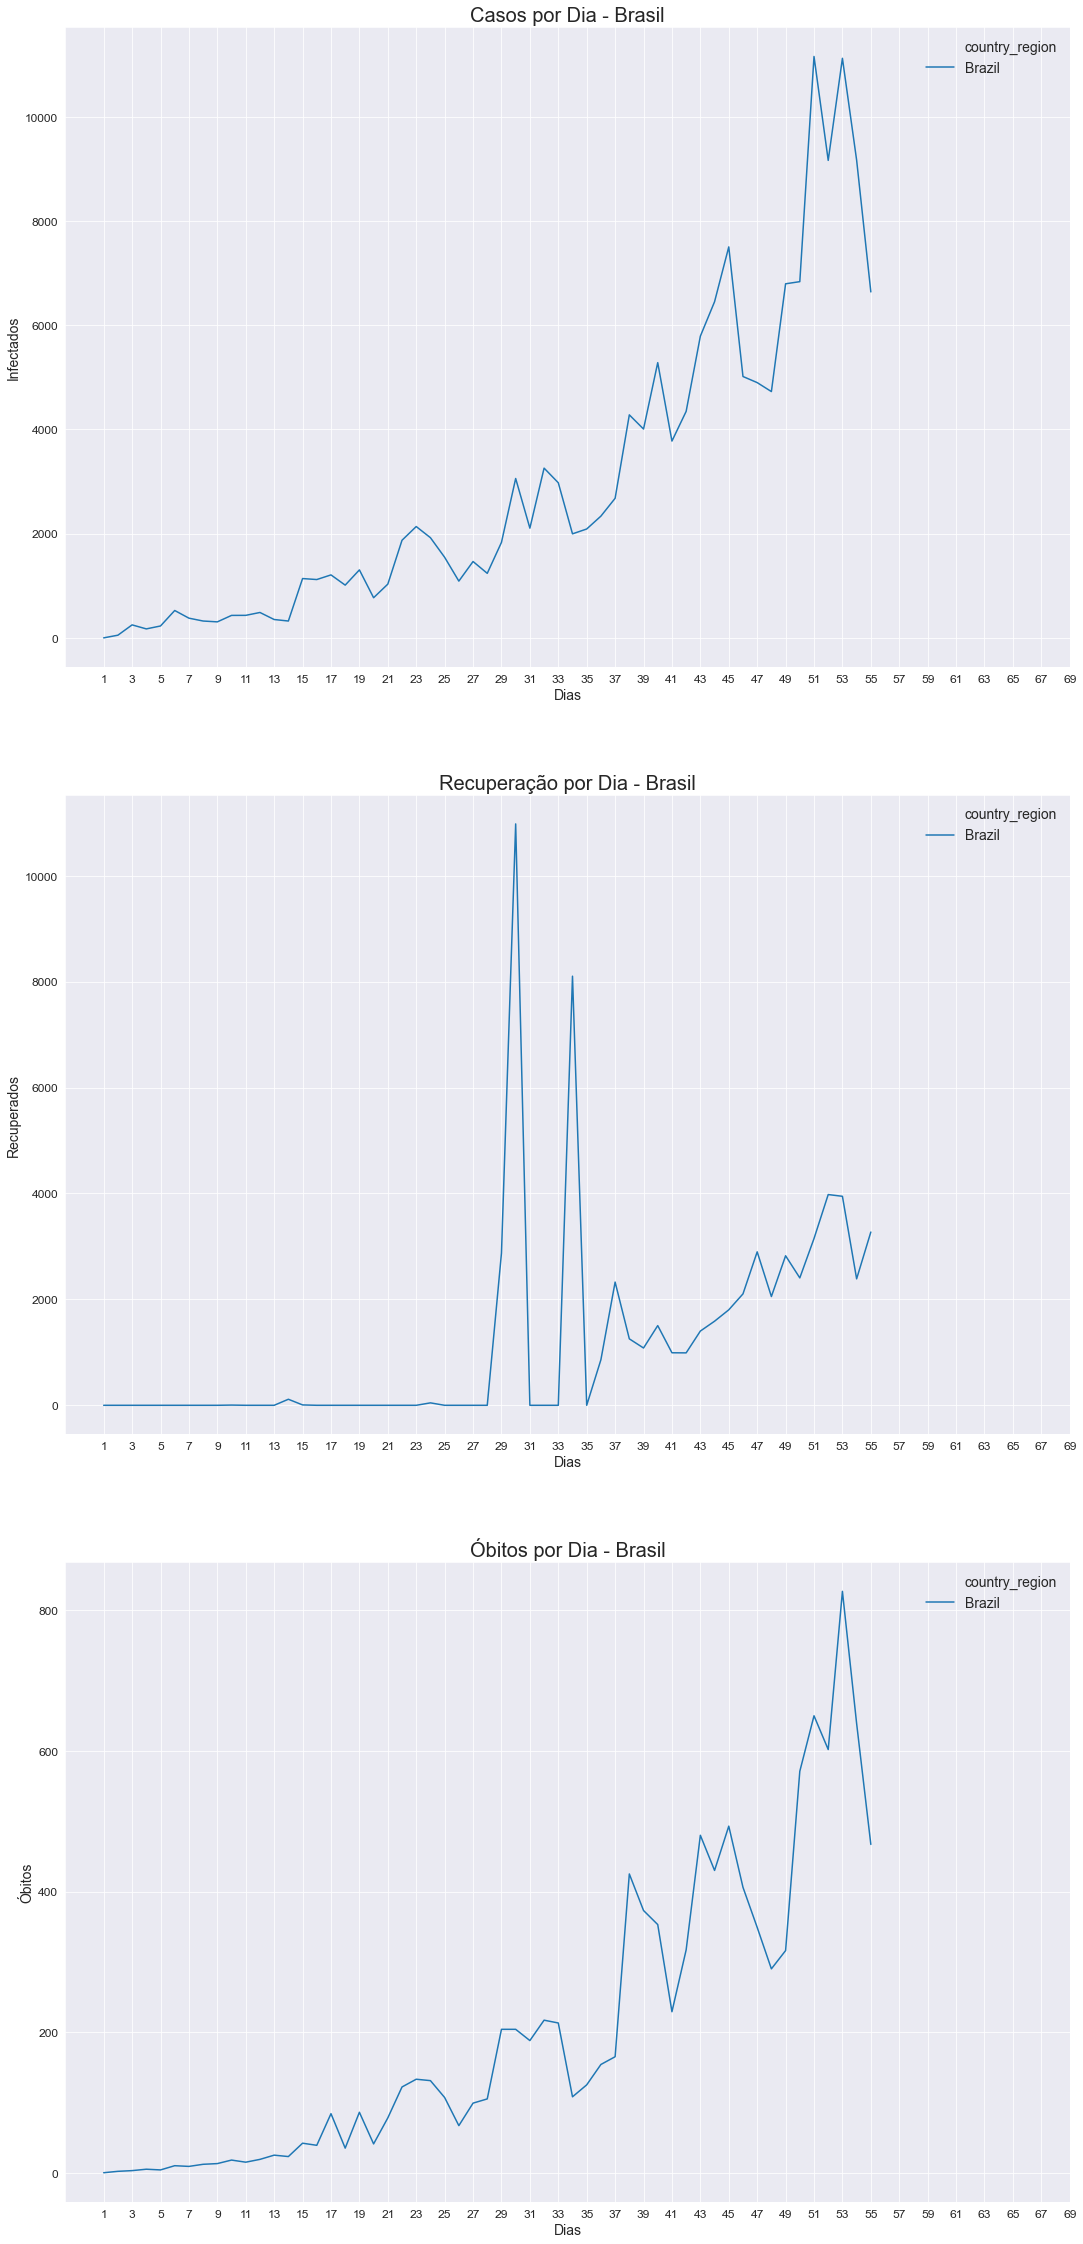

In [119]:
# Gerar gráficos Brasil, com posição diária
fig_dims = (18, 40)
fig, ax = plt.subplots(figsize=fig_dims, nrows=3, ncols=1)
sns.set_style("darkgrid")

# Confirmados
sns.lineplot(x="num_days", y="confirmed_day", hue="country_region", ax=ax[0], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[0].set_xticks(np.arange(1, 70, 2.0))
ax[0].tick_params(axis='both', which='major', labelsize=12)
#ax[0].set_yticks(np.arange(0, 750000, 25000.0))
ax[0].legend(fontsize=14, frameon=False)
ax[0].set_xlabel("Dias", fontsize=14)
ax[0].set_ylabel("Infectados", fontsize=14)
ax[0].set_title("Casos por Dia - Brasil", fontsize=20)

# Recuperados
sns.lineplot(x="num_days", y="recovered_day", hue="country_region", ax=ax[1], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[1].set_xticks(np.arange(1, 70, 2.0))
ax[1].tick_params(axis='both', which='major', labelsize=12)
#ax[1].set_yticks(np.arange(0, 100000, 5000.0))
ax[1].legend(fontsize=14, frameon=False)
ax[1].set_xlabel("Dias", fontsize=14)
ax[1].set_ylabel("Recuperados", fontsize=14)
ax[1].set_title("Recuperação por Dia - Brasil", fontsize=20)

# Óbitos
sns.lineplot(x="num_days", y="deaths_day", hue="country_region", ax=ax[2], data=complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas())
ax[2].set_xticks(np.arange(1, 70, 2.0))
ax[2].tick_params(axis='both', which='major', labelsize=12)
#ax[2].set_yticks(np.arange(0, 50000, 2500.0))
ax[2].legend(fontsize=14, frameon=False)
ax[2].set_xlabel("Dias", fontsize=14)
ax[2].set_ylabel("Óbitos", fontsize=14)
ax[2].set_title("Óbitos por Dia - Brasil", fontsize=20)

plt.show()

In [120]:
# Verificar Brasil
complete_world_df.filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()

,province_state,country_region,lat,long,date,confirmed,recovered,deaths,num_days,confirmed_day,recovered_day,deaths_day
0,None,Brazil,-14.235,-51.925301,2020-03-17,321,2,1,1,0,0,0
1,None,Brazil,-14.235,-51.925301,2020-03-18,372,2,3,2,51,0,2
2,None,Brazil,-14.235,-51.925301,2020-03-19,621,2,6,3,249,0,3
3,None,Brazil,-14.235,-51.925301,2020-03-20,793,2,11,4,172,0,5
4,None,Brazil,-14.235,-51.925301,2020-03-21,1021,2,15,5,228,0,4
5,None,Brazil,-14.235,-51.925301,2020-03-22,1546,2,25,6,525,0,10
6,None,Brazil,-14.235,-51.925301,2020-03-23,1924,2,34,7,378,0,9
7,None,Brazil,-14.235,-51.925301,2020-03-24,2247,2,46,8,323,0,12
8,None,Brazil,-14.235,-51.925301,2020-03-25,2554,2,59,9,307,0,13
9,None,Brazil,-14.235,-51.925301,2020-03-26,2985,6,77,10,431,4,18


## Forecast usando Facebook Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Confirmados: 10 dias
           ds          yhat    yhat_lower    yhat_upper
55 2020-05-11   8294.980099   7164.487229   9390.197773
56 2020-05-12   9042.073954   7898.936478  10148.322512
57 2020-05-13   9991.591129   8889.322438  11203.644490
58 2020-05-14  10075.263249   9049.292825  11220.546232
59 2020-05-15  10134.060052   9045.085506  11245.438171
60 2020-05-16  10088.316192   9006.684930  11246.923003
61 2020-05-17   9536.310276   8448.131432  10666.623056
62 2020-05-18  10146.062981   9022.789465  11244.001300
63 2020-05-19  10893.156835   9763.315916  11945.371176
64 2020-05-20  11842.674010  10693.454101  12966.742548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Recuperados: 10 dias
           ds         yhat   yhat_lower   yhat_upper
55 2020-05-11  2415.178735   425.385843  4625.795916
56 2020-05-12  3029.440376   884.208210  5107.336457
57 2020-05-13  4341.368369  2118.411046  6472.996117
58 2020-05-14  2971.807899   959.972064  5105.587464
59 2020-05-15  2977.430618   830.356687  5176.685075
60 2020-05-16  2934.676291   870.181159  5159.079585
61 2020-05-17  3888.589135  1904.354433  6024.643650
62 2020-05-18  2878.697000   765.798819  4969.259804
63 2020-05-19  3492.958641  1382.607438  5666.115917
64 2020-05-20  4804.886634  2636.860586  6922.442819


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Previsão Óbitos: 10 dias
           ds        yhat  yhat_lower  yhat_upper
55 2020-05-11  529.970028  451.113078  617.069449
56 2020-05-12  628.193627  547.548062  711.359565
57 2020-05-13  639.251911  557.584571  730.559526
58 2020-05-14  682.431948  594.306110  768.857743
59 2020-05-15  692.237067  609.546556  777.663357
60 2020-05-16  664.112568  581.496134  746.863559
61 2020-05-17  610.238129  523.504741  698.712782
62 2020-05-18  643.234874  565.483249  733.092820
63 2020-05-19  741.458472  656.537391  821.574867
64 2020-05-20  752.516756  670.216989  839.141680


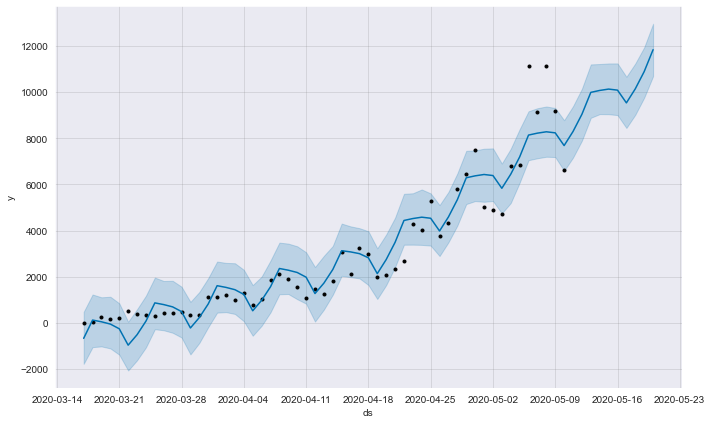

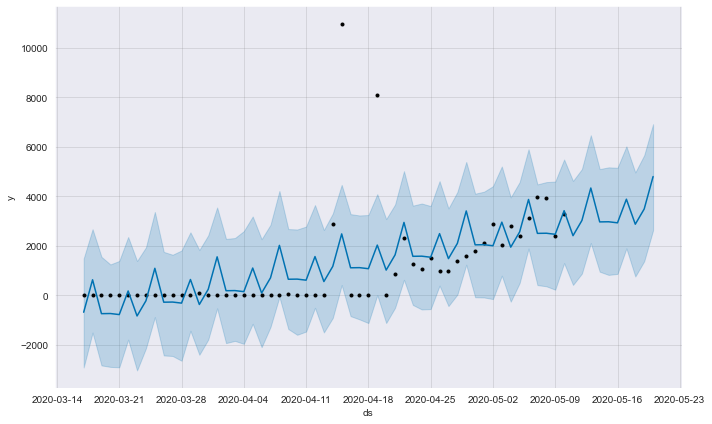

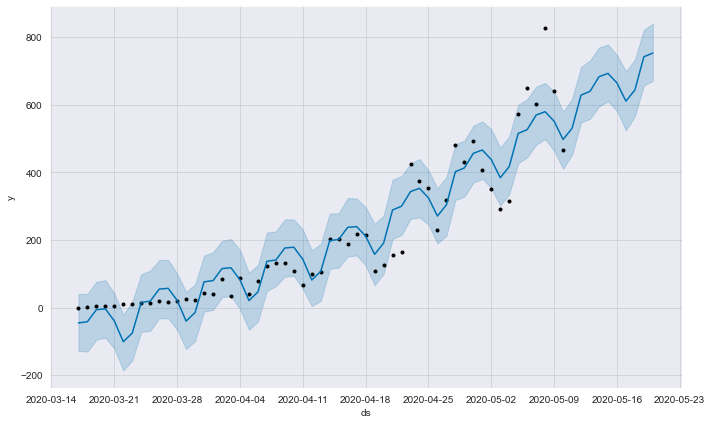

In [121]:
# confirmados
X = complete_world_df.selectExpr('date as ds', 'confirmed_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_confirmed = Prophet()
model_confirmed.fit(X)
future_confirmed_brazil = model_confirmed.make_future_dataframe(periods=10)
forecast_confirmed_brazil = model_confirmed.predict(future_confirmed_brazil)
print('Previsão Confirmados: 10 dias')
print(forecast_confirmed_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# recuperados
X = complete_world_df.selectExpr('date as ds', 'recovered_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_recovered = Prophet()
model_recovered.fit(X)
future_recovered_brazil = model_recovered.make_future_dataframe(periods=10)
forecast_recovered_brazil = model_recovered.predict(future_recovered_brazil)
print('Previsão Recuperados: 10 dias')
print(forecast_recovered_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# óbitos
X = complete_world_df.selectExpr('date as ds', 'deaths_day as y').filter(complete_world_df.country_region.isin(["Brazil"])).toPandas()
model_deaths = Prophet()
model_deaths.fit(X)
future_deaths_brazil = model_deaths.make_future_dataframe(periods=10)
forecast_deaths_brazil = model_deaths.predict(future_deaths_brazil)
print('Previsão Óbitos: 10 dias')
print(forecast_deaths_brazil[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# Gráficos Forecast FBProphet
fig1 = model_confirmed.plot(forecast_confirmed_brazil)
fig2 = model_recovered.plot(forecast_recovered_brazil)
fig3 = model_deaths.plot(forecast_deaths_brazil)

## Datasets COVID19

- https://data.brasil.io/dataset/covid19/_meta/list.html
- https://github.com/CSSEGISandData/COVID-19
- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
- https://github.com/beoutbreakprepared/nCoV2019?files=1
- https://www.kaggle.com/smid80/coronavirus-covid19-tweets
- https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures
- https://www.kaggle.com/unanimad/corona-virus-brazil
- https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
- https://github.com/github/covid-19-repo-data
- https://github.com/datasets/covid-19
- https://github.com/pomber/covid19
- https://github.com/joachim-gassen/tidy_covid19

## Dados Demográficos (Brasil e Mundo)

- https://data.worldbank.org/indicator/sp.pop.totl
- https://www.kaggle.com/crisparada/brazilian-cities
- https://www.kaggle.com/fernandol/countries-of-the-world

## Artigos, estudos e recursos - COVID-19
- https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
- https://medium.com/data-for-science/epidemic-modeling-102-all-covid-19-models-are-wrong-but-some-are-useful-c81202cc6ee9
- https://maksimekin.github.io/COVID19-Literature-Clustering/plots/t-sne_covid-19_interactive.html
- https://medium.com/@flohagenbuch/vemos-luz-no-fim-do-túnel-covid-19-96663d3cf1ed
- https://investnews.com.br/cafeina/novo-estudo-contesta-previsoes-sobre-mortes-pela-covid-19-no-brasil/
- https://science.sciencemag.org/content/early/2020/04/14/science.abb5793.full
- https://www.medrxiv.org/content/10.1101/2020.02.27.20028027v3
- https://towardsdatascience.com/5-datasets-about-covid-19-you-can-use-right-now-46307b1406a?gi=8f8a40a7b45b
- https://www.kaggle.com/brandao/covid19-reduzindo-falsos-negativos
- https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions
- https://towardsdatascience.com/top-5-r-resources-on-covid-19-coronavirus-1d4c8df6d85f

## Papers, Estudos, Artigos - Séries Temporais
- https://peerj.com/preprints/3190/